# Built-In Fully Connected Neural Network on MNIST 

In this notebook, we show how to train and evaluate a fully connected neural network on the MNIST classification problem using the Concrete-ML library, our open-source privacy-preserving machine learning framework based on fully homomorphic encryption (FHE).

Using a built-in model, this example emphasizes on the API's ease-of-use by illustrating the few main steps needed to create an efficient inference-secured Neural Network classifier. Thanks to the internal implementation of Quantize Aware Training (QAT) techniques, this Concrete-ML `NeuralNetCLassifier` model reaches a high accuracy score. More information about QAT is available in the [QAT notebook](QuantizationAwareTraining.ipynb).

More precisely, the model is trained on clear data and its accuracy score is computed using FHE simulation, which is expected to be the same as if it was done in FHE. Then, the inference is executed in FHE on a few samples.


### Import libraries

We import the required packages.

In [1]:
import time

import matplotlib.pyplot as plt
import numpy as np
from concrete.numpy import Configuration
from IPython.display import clear_output
from joblib import Memory
from sklearn.datasets import fetch_openml
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from torch import nn
from tqdm import tqdm

from concrete.ml.sklearn import NeuralNetClassifier

### Load the data

We download the train and test data sets from OpenML. 

In [2]:
# scikit-learn's fetch_openml method doesn't handle local cache:
# https://github.com/scikit-learn/scikit-learn/issues/18783#issuecomment-723471498
# This is a workaround that prevents downloading the data every time the notebook is ran
memory = Memory("./data/MNIST")
fetch_openml_cached = memory.cache(fetch_openml)

# Fetch the MNIST data set, with inputs already flattened
mnist_dataset = fetch_openml_cached("mnist_784")

________________________________________________________________________________
[Memory] Calling sklearn.datasets._openml.fetch_openml...
fetch_openml('mnist_784')
____________________________________________________fetch_openml - 40.3s, 0.7min


We now need to normalize the values and split the inputs and targets into a test and train data set. 

In [3]:
# Define max, mean and std values for the MNIST data set
max_value = 255
mean = 0.1307
std = 0.3081

# Normalize the training data
data = (mnist_dataset.data) / max_value
data = ((data - mean) / std).round(decimals=4)

# Convert the Pandas data frames to Numpy array and cast the targets to int64
# FIXME: https://github.com/zama-ai/concrete-ml-internal/issues/2327
# FIXME: https://github.com/zama-ai/concrete-ml-internal/issues/2339
data = data.to_numpy()
target = mnist_dataset.target.to_numpy(dtype=np.int64)

In [4]:
test_size = 10000
x_train, x_test = train_test_split(data, test_size=test_size, random_state=0)
y_train, y_test = train_test_split(target, test_size=test_size, random_state=0)

Let's plot the first images from the train data.

In [5]:
def plot_samples(data, targets, n_samples=5, title="Train target"):
    # MNIST images are originally of shape 28x28 with grayscale values
    samples_to_plot = data[:n_samples].reshape((n_samples, 28, 28))

    fig = plt.figure(figsize=(30, 30))

    for i in range(n_samples):
        subplot = fig.add_subplot(1, n_samples, i + 1)
        subplot.set_title(f"{title}: {targets[i]}", fontsize=15)
        subplot.imshow(samples_to_plot[i], cmap="gray", interpolation="nearest")

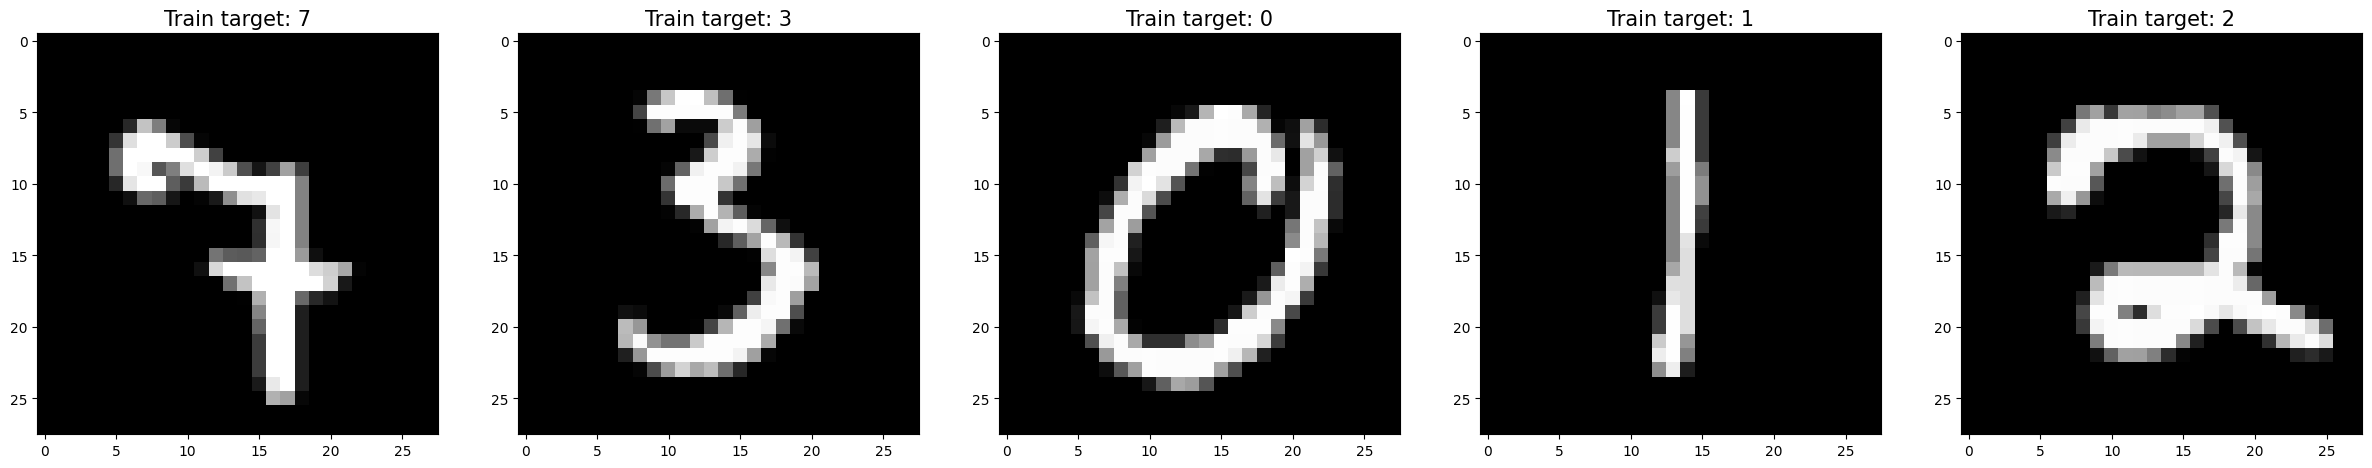

In [6]:
plot_samples(x_train, y_train)

### Instantiate the model

This step is easy to achieve as we use a built-in Fully Connected Neural Network. Only a few input parameters are needed:
- `module__n_layers`: number of Fully Connected layers to use in the model
- `module__n_w_bits` and `module__n_a_bits`: respectively the number of bits to use for quantizing the weight and input/activation values as the FHE can currently only compute integers. These numbers should not become too large as it can cause the compilation step to fail (see Compile section below)
- `module__n_accum_bits`: The maximal allowed bit-width to target for intermediate accumulators. It is currently set to 15 as the actual maximum bit width reached during compilation can be up to one bit higher than this targeted value, in this case 16, which is the maximal value that Concrete-ML currently supports.
-  `module__n_outputs`: Number of output classes
- `module__n_hidden_neurons_multiplier`: A factor that is multiplied by the maximal number of active (non-zero weight) neurons for every layer. Default to 4 but set to 1 here in order to speed up all executions without changing the test accuracy by much. More detail in the qqn documentation. 
- `module__input_dim`: The inputs' shape
- `module__activation_function`: The activation function to use
- `max_epochs`: The number of epochs to consider

In [7]:
params = {
    "module__n_layers": 2,
    "module__n_w_bits": 4,
    "module__n_a_bits": 4,
    "module__n_accum_bits": 15,
    "module__n_outputs": 10,
    "module__n_hidden_neurons_multiplier": 1,
    "module__input_dim": x_train.shape[1],
    "module__activation_function": nn.Sigmoid,
    "max_epochs": 10,
}

model = NeuralNetClassifier(**params)

### Train the model

The fit method handles Pandas DataFrame as inputs.

In [8]:
model.fit(X=x_train, y=y_train)

clear_output()

### Compute predictions in the clear

We then compute the accuracy score reached by the model when executed in the clear. It is important to understand that no FHE computations are done here. This step is not necessary but helps illustrate what results should we expect from the model. It is therefore used to demonstrate that FHE computations are exact, meaning the FHE accuracy score will exactly match this very one.

In [9]:
y_preds_clear = model.predict(x_test)

print(f"The test accuracy of the clear model is {accuracy_score(y_test, y_preds_clear):.2f}")

The test accuracy of the clear model is 0.97


### Compile the model with FHE Simulation

A Concrete-ML model needs to be compiled on an inputset, usually the train set or one of its sub-set, before being able to predict. This step creates a FHE circuit, which essentially saves elements found in the model's inference (graph of operations, shapes, bit-width precisions, etc.) needed for the compiler when executing the predictions in FHE during the `predict` method. 

The maximum bit-width that can be reached by any values (inputs, weights, accumulators) in this circuit is currently 16-bits. If this limit is exceeded, the compilation fails and the user needs to change some of the model's parameters (e.g. decrease the number of quantization bits or decrease `module__n_accum_bits`). 

<!--- 
Make it compile in non-VL when 2037 is done
FIXME: https://github.com/zama-ai/concrete-ml-internal/issues/2307 
-->

In [10]:
# Enable unsafe features in order to be able to simulate in FHE, through the use of the
# Virtual Library (VL)
configuration = Configuration(
    enable_unsafe_features=True,
    p_error=None,  # To avoid any confusion: we are always using kwarg p_error
    global_p_error=None,  # To avoid any confusion: we are always using kwarg global_p_error
)

# Reduce the inputset's length to make the compilation time faster
# The inputset should be large enough to be representative of the input data
# Also, note that the compile method only handles Numpy arrays type
inputset = x_train[:1000]
simulated_fhe_circuit = model.compile(inputset, configuration=configuration, use_virtual_lib=True)

# Print the circuit's maximum bit-width reached during compilation
print(f"Circuit of {simulated_fhe_circuit.graph.maximum_integer_bit_width()} bits (FHE simulation)")

Circuit of 12 bits (FHE simulation)


### Compute the accuracy score with FHE simulation

Now, we compute the accuracy score reached by the FHE model with FHE simulation. The accuracy score obtained by simulation, which is faster, is expected to be the same as the one obtained in FHE.

In [11]:
# Evaluate the model using the Virtual Library
y_preds_simulated = model.predict(x_test, execute_in_fhe=True)

print(
    "The test accuracy (with FHE simulation) of the FHE model is "
    f"{accuracy_score(y_test, y_preds_simulated):.2f}"
)

The test accuracy (with FHE simulation) of the FHE model is 0.97


In [12]:
def run_inference(model, x_test):

    # Execute the predictions using the given model
    predictions = []
    time_begin = time.time()
    for x in tqdm(x_test):
        x = np.expand_dims(x, axis=0)
        y_preds = model.predict(x, execute_in_fhe=True)
        predictions.append(y_preds[0])
    print(f"Execution time: {(time.time() - time_begin) / len(x_test):.2f} seconds per sample\n")

    return predictions

In [13]:
# Reduce the test set
n_samples = 3
x_test_sample = x_test[:n_samples]
y_test_sample = y_test[:n_samples]

# Execute the predictions using FHE simulation on a few samples
simulated_fhe_predictions = run_inference(model, x_test_sample)

100%|██████████| 3/3 [00:00<00:00, 361.90it/s]

Execution time: 0.00 seconds per sample



### Compute predictions in FHE

Now, let's compute some predictions in FHE. In order to make the computations faster, we will consider a sample of the original test set and compare these results to the expected values.

First, we need to compile the model without the Virtual Library.

In [14]:
from concrete.numpy import DebugArtifacts

artifacts = DebugArtifacts("./.fcnn_artifacts")


# Reduce the inputset's length to make the compilation time faster
# Also convert it to a Numpy array as the compile method only handles this input type
# FIXME: https://github.com/zama-ai/concrete-ml-internal/issues/1167
inputset = x_train[:1000]
fhe_circuit = model.compile(inputset, compilation_artifacts=artifacts)

artifacts.export()

# Print the circuit's maximum bit-width reached during compilation
print(f"FHE circuit of {fhe_circuit.graph.maximum_integer_bit_width()} bits")

FHE circuit of 12 bits


Even though this is not mandatory, we can execute the key generation separately from the predictions in order to be able to measure its execution time.

In [15]:
time_begin = time.time()
fhe_circuit.client.keygen(force=True)
print(f"Key generation time: {time.time() - time_begin:.2f} seconds")

Key generation time: 35.42 seconds


Let's predict a few samples using FHE. Be aware that a single execution can take up to several dozens of minutes.

In [16]:
# Execute the predictions using FHE on a few samples
fhe_predictions = run_inference(model, x_test_sample)

print("Expected values: ", list(y_test_sample))
print("Simulated prediction values:", simulated_fhe_predictions)
print("FHE prediction values:", fhe_predictions)

100%|██████████| 3/3 [42:50<00:00, 856.91s/it]

Execution time: 856.92 seconds per sample

Expected values:  [0, 4, 1]
Simulated prediction values: [0, 4, 1]
FHE prediction values: [0, 4, 1]


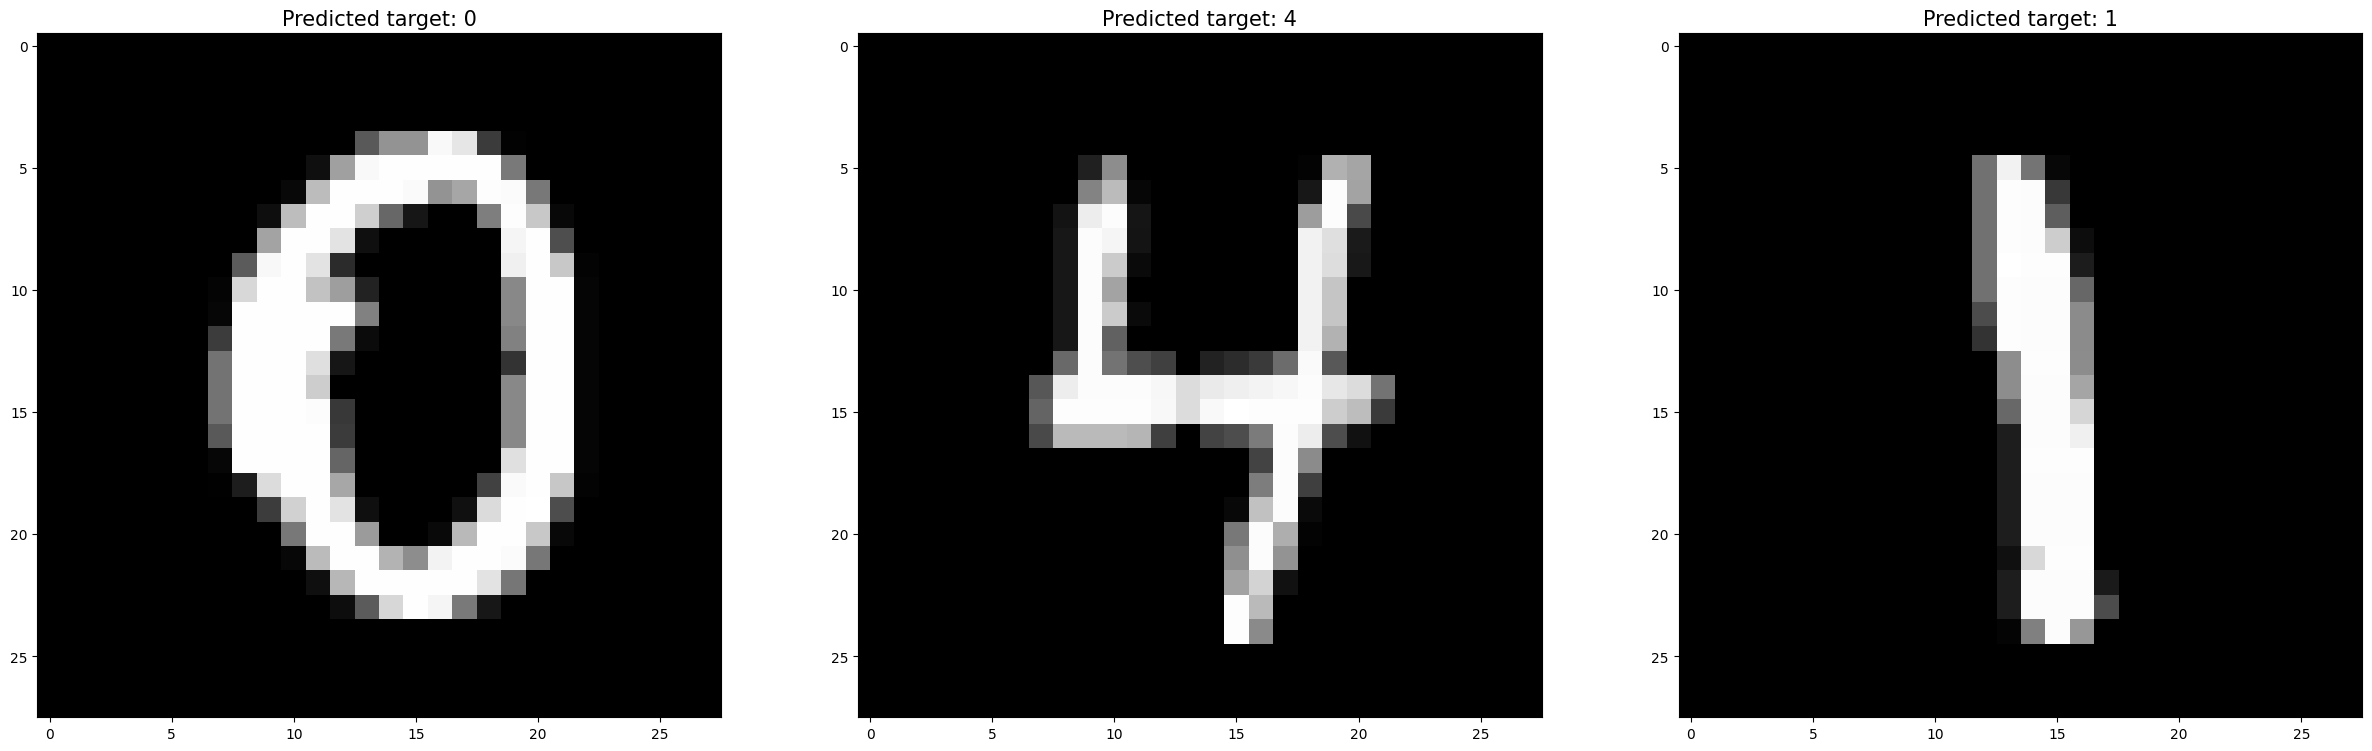

In [17]:
plot_samples(x_test, fhe_predictions, n_samples=n_samples, title="Predicted target")

## Conclusion

In this notebook, we showed how to use a built-in Fully Connected Neural Network classifier on the MNIST data set using the Concrete-ML library in order to make its inference completely secure.

Training, compiling and evaluation such a model is intuitive as our API follows most common Machine Learning APIs. In fact, only a few additional parameters related to quantization are requested, such as `module__n_w_bits`, `module__n_a_bits` or `module__n_accum_bits`. Thanks to the internal implementation of Quantize Aware Training (QAT) techniques, the Concrete-ML `NeuralNetCLassifier` model reached a high accuracy score.

As of December 2022, a single FHE execution takes about 15 minutes on a [c5.4xlarge AWS EC2 instance](https://docs.aws.amazon.com/AWSEC2/latest/UserGuide/cpu-options-supported-instances-values.html), which uses 8 cores. However, this executions time is expected to be improved in future releases.  